In [ ]:
import pandas as pd
import dask.dataframe as dd

# Load the CSV file into a Dask DataFrame
df = dd.read_csv('../data/raw/data_raw.csv')

# Optionally, display the first few rows
df.head()


In [ ]:
category_counts_AMS_TRANS_RSN_CD = df['AMS_trans_rsn_cd'].value_counts().compute()
print("category_counts_AMS_TRANS_RSN_CD", category_counts_AMS_TRANS_RSN_CD)


In [ ]:
with open('../data/vpn_txt/vpn_ips.txt', 'r') as file:
    ip_set = set(file.read().splitlines())

# Filter the DataFrame to exclude rows with IPs in the ip_set
filtered_df = df[~df['CLNT_RMT_IP'].isin(ip_set)]

# Optionally, compute to bring the result into memory (if necessary)
filtered_df = filtered_df.compute()
print(filtered_df.head())


In [ ]:
# category_counts_AMS_TRANS_RSN_CD_post_vpn_filter = filtered_df['AMS_trans_rsn_cd'].value_counts().compute()
# print("category_counts_AMS_TRANS_RSN_CD", category_counts_AMS_TRANS_RSN_CD_post_vpn_filter)
# Number of rows (requires computation)
num_rows = len(filtered_df)  # Or, data.shape[0].compute() if you want to be explicit

# Number of columns (does not require computation)
num_columns = len(filtered_df.columns)

# Display the shape
print("Shape:", (num_rows, num_columns))


In [ ]:
filtered_df.columns

In [ ]:
filtered_df.to_csv('../data/processed/data_vpn_removed.csv')

In [1]:
import pandas as pd
data = pd.read_csv('../data/processed/data_vpn_removed.csv')

In [2]:
data = data.drop('Unnamed: 0', axis=1)
data.columns

Index(['CLNT_RMT_IP', 'AMS_trans_rsn_cd', 'BRWSR_NAME', 'CLICK_TS'], dtype='object')

In [3]:
import numpy as np
data['status'] = np.where(data['AMS_trans_rsn_cd'] == 0, 1, 0)


In [4]:
data.head()

,CLNT_RMT_IP,AMS_trans_rsn_cd,BRWSR_NAME,CLICK_TS,status
0,194.182.199.141,0,Mozilla/5.0 (iPhone; CPU iPhone OS 18_0_1 like...,2024-10-23 02:59:14,1
1,37.163.216.86,0,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,2024-10-23 02:58:23,1
2,93.224.234.210,0,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2024-10-23 02:57:50,1
3,109.157.109.33,0,Mozilla/5.0 (iPhone; CPU iPhone OS 11_0 like M...,2024-10-23 02:57:26,1
4,203.122.13.189,0,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2024-10-23 02:57:20,1


In [5]:
category_counts = data['AMS_trans_rsn_cd'].value_counts()
print(category_counts)

AMS_trans_rsn_cd
0    805955
6     95564
7     55622
8     10976
4      9753
2       554
5         4
Name: count, dtype: int64


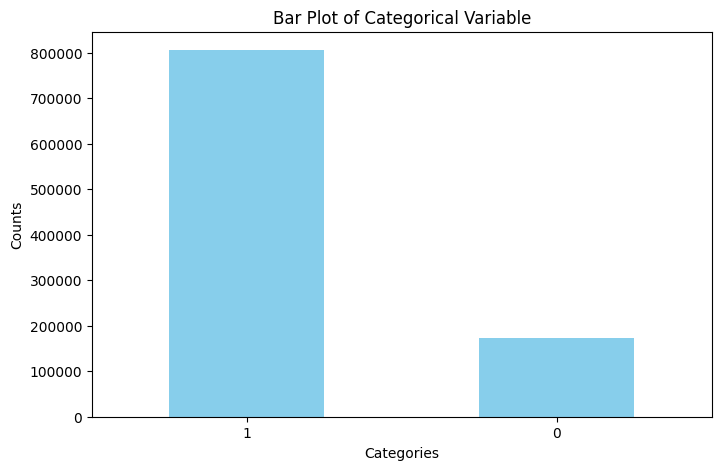

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
category_counts = data['status'].value_counts()
plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Bar Plot of Categorical Variable')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

In [7]:
from user_agents import parse
import pandas as pd
import swifter  # for parallel processing with Pandas (install with `pip install swifter`)

# Dictionary to cache parsed user-agent strings and reduce redundant parsing
user_agent_cache = {}

def extract_user_agent_features_optimized(ua_string):
    # Check if this user-agent string has already been parsed
    if ua_string in user_agent_cache:
        return user_agent_cache[ua_string]
    
    # Parse the user agent string and store parsed results in a variable
    user_agent = parse(ua_string)
    
    # Extract required features
    result = {
        'browser': user_agent.browser.family,
        # 'browser_version': user_agent.browser.version_string,
        'os': user_agent.os.family,
        # 'os_version': user_agent.os.version_string,
        'device_type': (
    'mobile' if user_agent.is_mobile else
    'desktop' if user_agent.is_pc else
    'tablet' if user_agent.is_tablet else
    'bot' if user_agent.is_bot else 'other'
        )
    }
    
    # Store result in the cache
    user_agent_cache[ua_string] = result
    
    return result

# Apply optimized function to the user-agent column with parallel processing using swifter
df_user_agent_features = data['BRWSR_NAME'].swifter.apply(extract_user_agent_features_optimized).apply(pd.Series)



Pandas Apply:   0%|          | 0/978428 [00:00<?, ?it/s]

In [15]:
# data.head()
df_os_browser = pd.concat([data, df_user_agent_features], axis=1)


In [16]:
df_os_browser.columns

Index(['CLNT_RMT_IP', 'AMS_trans_rsn_cd', 'BRWSR_NAME', 'CLICK_TS', 'status',
       'browser', 'os', 'device_type'],
      dtype='object')

In [17]:
df_os_browser = df_os_browser.drop('BRWSR_NAME', axis=1)
df_os_browser.columns

Index(['CLNT_RMT_IP', 'AMS_trans_rsn_cd', 'CLICK_TS', 'status', 'browser',
       'os', 'device_type'],
      dtype='object')

In [ ]:
category_counts_AMS_TRANS_RSN_CD = data['AMS_trans_rsn_cd'].value_counts()
print(category_counts_AMS_TRANS_RSN_CD)


category_counts_AMS_TRANS_RSN_CD = data['status'].value_counts()
print(category_counts_AMS_TRANS_RSN_CD)


In [18]:
data=df_os_browser
category_counts_device_type = data['device_type'].value_counts()
print("category_counts_device_type", category_counts_device_type)

category_counts_os = data['os'].value_counts()
print("category_counts_os", category_counts_os)
#os to keep
# Android, iOS, Windows, Mac OS X, Linux, Ubuntu, Chrome OS
category_counts_browser = data['browser'].value_counts()
print("category_counts_browser", category_counts_browser)


category_counts_device_type device_type
mobile     562280
desktop    367367
bot         27018
tablet      14065
other        7698
Name: count, dtype: int64
category_counts_os os
Android                 296434
iOS                     283867
Windows                 280771
Mac OS X                 60787
Other                    29425
Linux                    15173
Ubuntu                    6018
Chrome OS                 3104
FreeBSD                    448
Gentoo                     441
Fedora                     365
SUSE                       333
Slackware                  300
OpenBSD                    191
CentOS                     178
Red Hat                    162
NetBSD                     145
Debian                     119
Arch Linux                  38
Mageia                      35
Mac OS                      29
Windows Phone               16
Symbian OS                  11
Solaris                     10
BlackBerry OS                7
Tizen                        4
Kindle          

In [19]:
category_counts_browser = data['browser'].value_counts()
print("category_counts_browser:\n", category_counts_browser.to_string())
# Chrome Mobile, Chrome, Mobile Safari, Mobile Safari, Edge , Firefox, Samsung Internet, Safari, Google, Chrome Mobile, Opera, FacebookBot, Facebook, ImagesiftBot

category_counts_browser:
 browser
Chrome Mobile                    225912
Chrome                           178600
Mobile Safari                    120170
Mobile Safari UI/WKWebView       102746
Edge                              88929
Firefox                           56841
Samsung Internet                  35713
Other                             34891
Safari                            26809
Google                            19876
Chrome Mobile iOS                 14253
Opera                             13624
FacebookBot                        9397
Facebook                           7887
ImagesiftBot                       5805
YandexBot                          3602
Chrome Mobile WebView              3405
Firefox Mobile                     2864
SemrushBot                         2642
Chromium                           2347
crawler                            2294
Edge Mobile                        2003
Applebot                           1967
Opera Mobile                       1659
WhatsA

In [20]:
def categorize_browser(browser_column):
    # Define the browsers to keep based on the 10,000 row threshold
    popular_browsers = ['Chrome Mobile', 'Chrome', 'Mobile Safari', 'Mobile Safari UI/WKWebView', 'Edge', 'Firefox', 'Samsung Internet', 'Safari', 'Google', 'Chrome Mobile', 'Opera', 'FacebookBot', 'Facebook', 'ImagesiftBot']

    # Apply the categorization
    browser_column = browser_column.apply(lambda x: x if x in popular_browsers else 'Other')
    return browser_column

# Function to categorize OS based on the 1% rule and keeping till Ubuntu
def categorize_os(os_column):
    # Define the OSes to keep based on the row threshold (up to Ubuntu)
    popular_os = ['Android', 'Other', 'iOS', 'Windows', 'Mac OS X', 'Linux', 'Ubuntu', 'Chrome OS']

    # Apply the categorization
    os_column = os_column.apply(lambda x: x if x in popular_os else 'Other')
    return os_column

# Apply categorization functions to the DataFrame
data['browser'] = categorize_browser(data['browser'])
data['os'] = categorize_os(data['os'])

# Display the transformed DataFrame
print(data)


            CLNT_RMT_IP  AMS_trans_rsn_cd             CLICK_TS  status  \
0       194.182.199.141                 0  2024-10-23 02:59:14       1   
1         37.163.216.86                 0  2024-10-23 02:58:23       1   
2        93.224.234.210                 0  2024-10-23 02:57:50       1   
3        109.157.109.33                 0  2024-10-23 02:57:26       1   
4        203.122.13.189                 0  2024-10-23 02:57:20       1   
...                 ...               ...                  ...     ...   
978423     88.58.91.125                 0  2024-10-23 00:00:21       1   
978424    91.205.43.131                 0  2024-10-23 00:00:33       1   
978425     99.45.63.130                 0  2024-10-23 00:01:50       1   
978426    92.40.177.191                 0  2024-10-23 00:01:17       1   
978427   90.219.255.178                 0  2024-10-23 00:01:46       1   

                           browser       os device_type  
0                    Mobile Safari      iOS      mobi

In [21]:
import re

# Function to check if the IP address is valid
def is_valid_ipv4(ip):
    if pd.isna(ip):  # Check for None or NaN
        return False
    pattern = r'^(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$'
    return re.match(pattern, ip) is not None

# Apply the function and create a mask for valid IP addresses
valid_ips_mask = data['CLNT_RMT_IP'].apply(is_valid_ipv4)

# Drop rows with invalid IP addresses
data = data[valid_ips_mask]

In [22]:
import socket
import struct
from sklearn.preprocessing import OneHotEncoder


# 1. Convert IP to integer
def ipv4_to_int(ip):
    return struct.unpack("!I", socket.inet_aton(ip))[0]

data['ip_as_int'] = data['CLNT_RMT_IP'].apply(ipv4_to_int)
data['CLICK_TS'] = pd.to_datetime(data['CLICK_TS'])


# 3. Extract features from datetime
data['year'] = data['CLICK_TS'].dt.year
data['month'] = data['CLICK_TS'].dt.month
data['day'] = data['CLICK_TS'].dt.day
data['hour'] = data['CLICK_TS'].dt.hour
data['minute'] = data['CLICK_TS'].dt.minute
data['second'] = data['CLICK_TS'].dt.second
# df['day_of_week'] = df['datetime'].dt.dayofweek  # Monday=0, Sunday=6

# 4. Drop original date and time columns
data.drop(['CLNT_RMT_IP', 'CLICK_TS'], axis=1, inplace=True)

# 5. Encode categorical features
categorical_features = ['browser', 'os', 'device_type', 'AMS_trans_rsn_cd']
df_encoded = pd.get_dummies(data, columns=categorical_features)

# Display the processed DataFrame
print(df_encoded)

C:\Users\Rajneesh\AppData\Local\Temp\ipykernel_8204\1342105451.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ip_as_int'] = data['CLNT_RMT_IP'].apply(ipv4_to_int)
C:\Users\Rajneesh\AppData\Local\Temp\ipykernel_8204\1342105451.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CLICK_TS'] = pd.to_datetime(data['CLICK_TS'])
C:\Users\Rajneesh\AppData\Local\Temp\ipykernel_8204\1342105451.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

        status   ip_as_int  year  month  day  hour  minute  second  \
0            1  3266758541  2024     10   23     2      59      14   
1            1   631494742  2024     10   23     2      58      23   
2            1  1575021266  2024     10   23     2      57      50   
3            1  1839033633  2024     10   23     2      57      26   
4            1  3413773757  2024     10   23     2      57      20   
...        ...         ...   ...    ...  ...   ...     ...     ...   
978423       1  1480219517  2024     10   23     0       0      21   
978424       1  1540172675  2024     10   23     0       0      33   
978425       1  1663909762  2024     10   23     0       1      50   
978426       1  1546170815  2024     10   23     0       1      17   
978427       1  1524367282  2024     10   23     0       1      46   

        browser_Chrome  browser_Chrome Mobile  ...  device_type_mobile  \
0                False                  False  ...                True   
1          

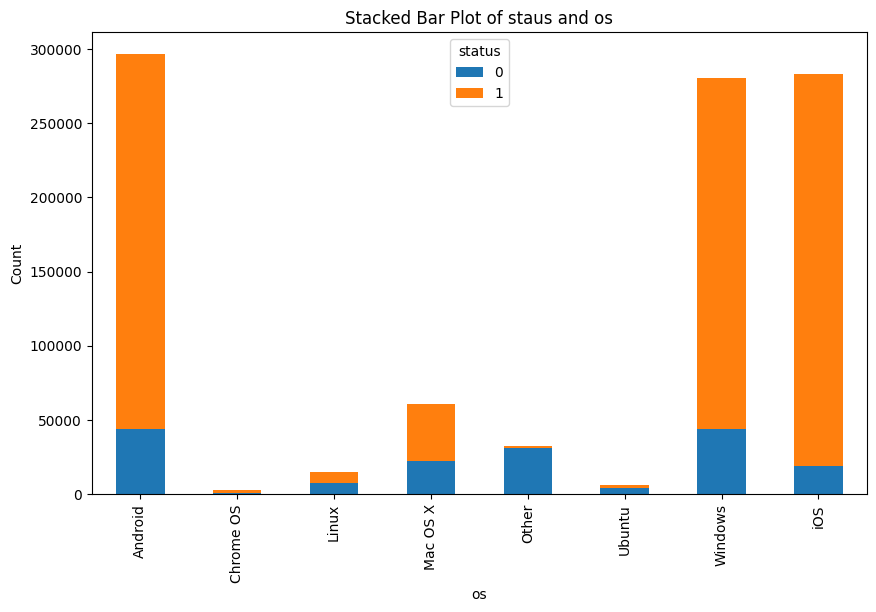

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

crosstab = pd.crosstab(data['os'], data['status'])

# Plot stacked bar plot
crosstab.plot(kind='bar', stacked=True, figsize=(10,6))

plt.title('Stacked Bar Plot of staus and os')
plt.xlabel('os')
plt.ylabel('Count')
plt.show()


In [25]:
from scipy.stats import chi2_contingency
# Chi-Square Test of Independence between categorical_feature1 and target
contingency_table = pd.crosstab(data['device_type'], data['status'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p_value}")


Chi-Square Statistic: 150668.56713210949
P-value: 0.0


In [29]:
data = df_encoded

In [30]:
data.shape

(977793, 42)

In [34]:
(len(data.columns))

42

In [32]:
from scipy.stats import chi2_contingency
# Chi-Square Test of Independence between categorical_feature1 and target
contingency_table = pd.crosstab(data['browser_Chrome'], data['status'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p_value}")

Chi-Square Statistic: 20975.907733508793
P-value: 0.0


In [33]:
cat_features = ['browser_Chrome', 'browser_Chrome Mobile', 'browser_Edge',
       'browser_Facebook', 'browser_FacebookBot', 'browser_Firefox',
       'browser_Google', 'browser_ImagesiftBot', 'browser_Mobile Safari',
       'browser_Mobile Safari UI/WKWebView', 'browser_Opera', 'browser_Other',
       'browser_Safari', 'browser_Samsung Internet', 'os_Android',
       'os_Chrome OS', 'os_Linux', 'os_Mac OS X', 'os_Other', 'os_Ubuntu',
       'os_Windows', 'os_iOS', 'device_type_bot', 'device_type_desktop',
       'device_type_mobile', 'device_type_other', 'device_type_tablet',
       'AMS_trans_rsn_cd_0', 'AMS_trans_rsn_cd_2', 'AMS_trans_rsn_cd_4',
       'AMS_trans_rsn_cd_5', 'AMS_trans_rsn_cd_6', 'AMS_trans_rsn_cd_7',
       'AMS_trans_rsn_cd_8']


for cat in cat_features:
    contingency_table = pd.crosstab(data[cat], data['status'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    print(cat)
    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p_value}")

browser_Chrome
Chi-Square Statistic: 20975.907733508793
P-value: 0.0
browser_Chrome Mobile
Chi-Square Statistic: 10070.124237818623
P-value: 0.0
browser_Edge
Chi-Square Statistic: 15037.70882325872
P-value: 0.0
browser_Facebook
Chi-Square Statistic: 1576.653698370577
P-value: 0.0
browser_FacebookBot
Chi-Square Statistic: 44300.12887295391
P-value: 0.0
browser_Firefox
Chi-Square Statistic: 1715.6773826444955
P-value: 0.0
browser_Google
Chi-Square Statistic: 4176.671593471635
P-value: 0.0
browser_ImagesiftBot
Chi-Square Statistic: 26650.678095373944
P-value: 0.0
browser_Mobile Safari
Chi-Square Statistic: 17382.87082257656
P-value: 0.0
browser_Mobile Safari UI/WKWebView
Chi-Square Statistic: 23435.221429604902
P-value: 0.0
browser_Opera
Chi-Square Statistic: 1962.3756774604635
P-value: 0.0
browser_Other
Chi-Square Statistic: 5534.69148173785
P-value: 0.0
browser_Safari
Chi-Square Statistic: 515.3172824242913
P-value: 4.419141353418641e-114
browser_Samsung Internet
Chi-Square Statistic: 6

In [40]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
# Assuming df_encoded is already prepared with one-hot encoding for categorical features

# Define features (X) and target variable (y)
X = data.drop('status', axis=1)
y = data['status']


In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

# Define the metrics you want to evaluate
metrics = ['accuracy', 'precision', 'recall', 'f1']

# Dictionary to store the results for each metric
train_scores_dict = {}
test_scores_dict = {}
model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42, n_jobs=-1)

for metric in metrics:
    # Generate the learning curve for each metric
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X,
        y,
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring=metric
    )

    # Calculate mean and standard deviation for train and test scores
    train_scores_dict[metric] = (train_scores.mean(axis=1), train_scores.std(axis=1))
    test_scores_dict[metric] = (test_scores.mean(axis=1), test_scores.std(axis=1))

# Plotting learning curves for each metric
plt.figure(figsize=(12, 10))

# Accuracy plot
plt.subplot(2, 2, 1)
train_mean, train_std = train_scores_dict['accuracy']
test_mean, test_std = test_scores_dict['accuracy']
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
plt.plot(train_sizes, test_mean, label='Validation Accuracy', color='orange')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='orange', alpha=0.1)
plt.title('Learning Curve - Accuracy')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()

# Precision plot
plt.subplot(2, 2, 2)
train_mean, train_std = train_scores_dict['precision']
test_mean, test_std = test_scores_dict['precision']
plt.plot(train_sizes, train_mean, label='Training Precision', color='blue')
plt.plot(train_sizes, test_mean, label='Validation Precision', color='orange')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='orange', alpha=0.1)
plt.title('Learning Curve - Precision')
plt.xlabel('Training Size')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.grid()

# Recall plot
plt.subplot(2, 2, 3)
train_mean, train_std = train_scores_dict['recall']
test_mean, test_std = test_scores_dict['recall']
plt.plot(train_sizes, train_mean, label='Training Recall', color='blue')
plt.plot(train_sizes, test_mean, label='Validation Recall', color='orange')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='orange', alpha=0.1)
plt.title('Learning Curve - Recall')
plt.xlabel('Training Size')
plt.ylabel('Recall')
plt.legend(loc='best')
plt.grid()

# F1 Score plot
plt.subplot(2, 2, 4)
train_mean, train_std = train_scores_dict['f1']
test_mean, test_std = test_scores_dict['f1']
plt.plot(train_sizes, train_mean, label='Training F1 Score', color='blue')
plt.plot(train_sizes, test_mean, label='Validation F1 Score', color='orange')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='orange', alpha=0.1)
plt.title('Learning Curve - F1 Score')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.grid()

plt.tight_layout()
plt.show()


In [43]:
data.to_csv('../data/processed/data_with_features.csv')

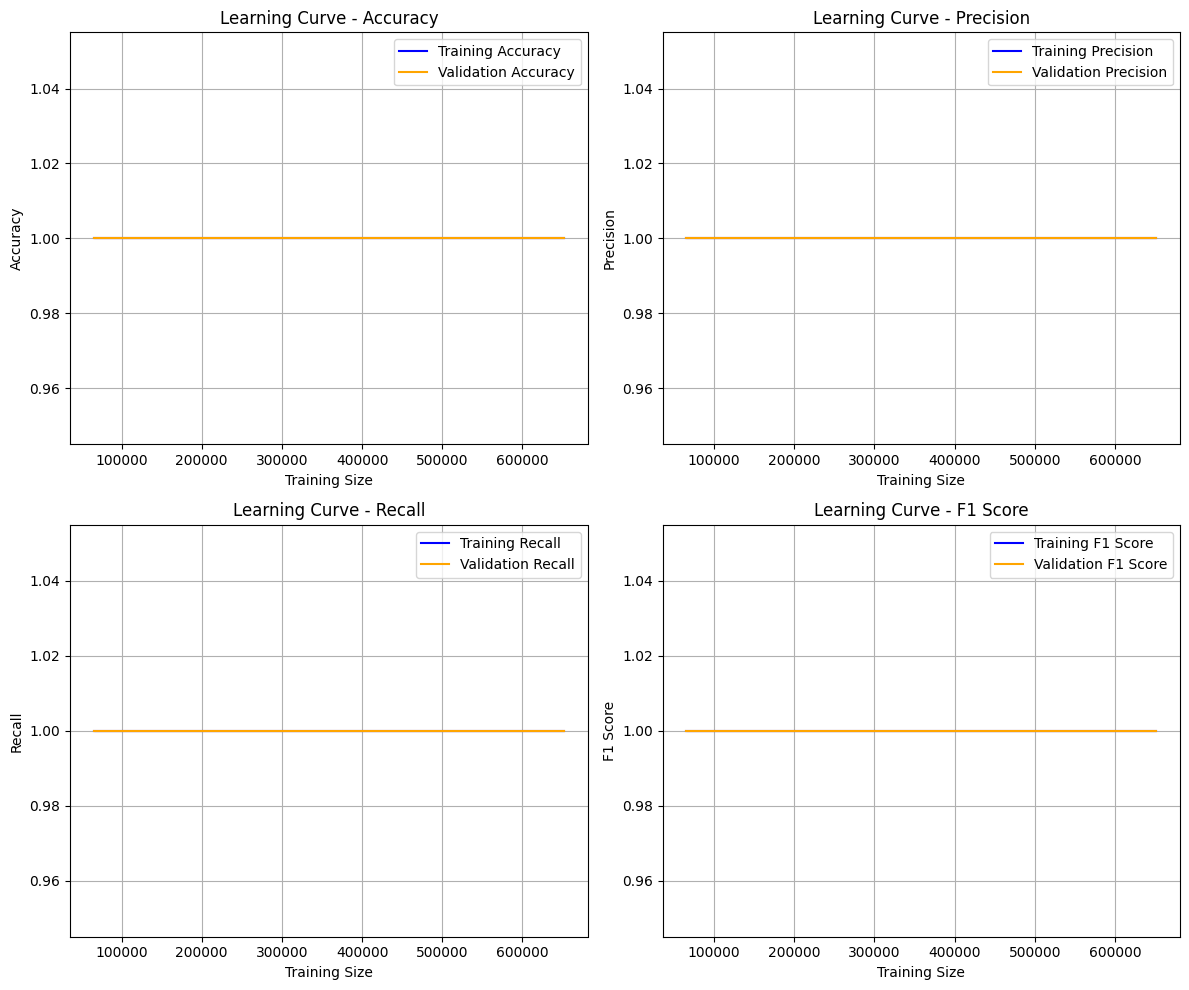

In [44]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

# Define metrics to evaluate
metrics = ['accuracy', 'precision', 'recall', 'f1']

# Dictionary to store the results for each metric
train_scores_dict = {}
test_scores_dict = {}
model = RandomForestClassifier(class_weight='balanced', n_estimators=50, random_state=42, n_jobs=-1)

# Reduced number of train sizes and CV folds
train_sizes = np.linspace(0.1, 1.0, 5)
cv_folds = 3

for metric in metrics:
    # Generate the learning curve for each metric with fewer train sizes and folds
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X,
        y,
        cv=cv_folds,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring=metric
    )

    # Calculate mean and standard deviation for train and test scores
    train_scores_dict[metric] = (train_scores.mean(axis=1), train_scores.std(axis=1))
    test_scores_dict[metric] = (test_scores.mean(axis=1), test_scores.std(axis=1))

# Plotting learning curves for each metric (no changes here)
plt.figure(figsize=(12, 10))

# Accuracy plot
plt.subplot(2, 2, 1)
train_mean, train_std = train_scores_dict['accuracy']
test_mean, test_std = test_scores_dict['accuracy']
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
plt.plot(train_sizes, test_mean, label='Validation Accuracy', color='orange')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='orange', alpha=0.1)
plt.title('Learning Curve - Accuracy')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()

# Precision plot
plt.subplot(2, 2, 2)
train_mean, train_std = train_scores_dict['precision']
test_mean, test_std = test_scores_dict['precision']
plt.plot(train_sizes, train_mean, label='Training Precision', color='blue')
plt.plot(train_sizes, test_mean, label='Validation Precision', color='orange')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='orange', alpha=0.1)
plt.title('Learning Curve - Precision')
plt.xlabel('Training Size')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.grid()

# Recall plot
plt.subplot(2, 2, 3)
train_mean, train_std = train_scores_dict['recall']
test_mean, test_std = test_scores_dict['recall']
plt.plot(train_sizes, train_mean, label='Training Recall', color='blue')
plt.plot(train_sizes, test_mean, label='Validation Recall', color='orange')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='orange', alpha=0.1)
plt.title('Learning Curve - Recall')
plt.xlabel('Training Size')
plt.ylabel('Recall')
plt.legend(loc='best')
plt.grid()

# F1 Score plot
plt.subplot(2, 2, 4)
train_mean, train_std = train_scores_dict['f1']
test_mean, test_std = test_scores_dict['f1']
plt.plot(train_sizes, train_mean, label='Training F1 Score', color='blue')
plt.plot(train_sizes, test_mean, label='Validation F1 Score', color='orange')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='orange', alpha=0.1)
plt.title('Learning Curve - F1 Score')
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.grid()

plt.tight_layout()
plt.show()


## VALIDATION ON NEW DATA

In [46]:
df = pd.read_csv('../data/raw/data_with_ts.csv')
category_counts_AMS_TRANS_RSN_CD = df['AMS_TRANS_RSN_CD'].value_counts()
print("category_counts_AMS_TRANS_RSN_CD", category_counts_AMS_TRANS_RSN_CD)


category_counts_AMS_TRANS_RSN_CD AMS_TRANS_RSN_CD
6    955133
7     25546
0     19122
8        94
4        85
2        20
Name: count, dtype: int64


In [48]:
with open('../data/vpn_txt/vpn_ips.txt', 'r') as file:
    ip_set = set(file.read().splitlines())

# Filter the DataFrame to exclude rows with IPs in the ip_set
filtered_df = df[~df['CLNT_RMT_IP'].isin(ip_set)]

# Optionally, compute to bring the result into memory (if necessary)
print(filtered_df.head())


         CLNT_RMT_IP                                         BRWSR_NAME  \
8      94.15.140.105  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   
13    90.212.167.240  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6...   
141   51.146.174.248  ebayUserAgent/eBayIOS;6.180.0;iOS;17.5.1;Apple...   
154   84.185.160.157  ebayUserAgent/eBayAndroid;6.180.1;Android;14;X...   
230  176.116.129.194  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   

     AMS_TRANS_RSN_CD             CLICK_TS  
8                   0  10/22/2024 10:23:59  
13                  0  10/22/2024 10:22:29  
141                 0  10/22/2024 10:21:35  
154                 0  10/22/2024 10:21:23  
230                 0  10/22/2024 10:20:47  


In [49]:
filtered_df.shape

(21377, 4)

In [50]:
filtered_df.to_csv('../data/processed/data_with_ts_vpn_removed.csv')

In [57]:
import pandas as pd
data = pd.read_csv('../data/processed/data_with_ts_vpn_removed.csv')
data.columns

Index(['Unnamed: 0', 'CLNT_RMT_IP', 'BRWSR_NAME', 'AMS_TRANS_RSN_CD',
       'CLICK_TS'],
      dtype='object')

In [58]:
data = data.drop('Unnamed: 0', axis=1)
data.columns

Index(['CLNT_RMT_IP', 'BRWSR_NAME', 'AMS_TRANS_RSN_CD', 'CLICK_TS'], dtype='object')

In [59]:
data = data.rename(columns={'AMS_TRANS_RSN_CD': 'AMS_trans_rsn_cd'})


In [60]:
import numpy as np
data['status'] = np.where(data['AMS_trans_rsn_cd'] == 0, 1, 0)


In [61]:
category_counts = data['AMS_trans_rsn_cd'].value_counts()
print(category_counts)

AMS_trans_rsn_cd
0    18637
6     2112
7      477
8       87
4       47
2       17
Name: count, dtype: int64


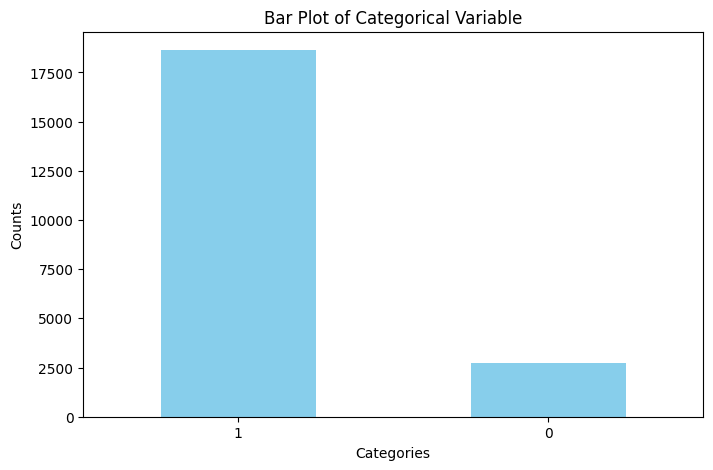

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
category_counts = data['status'].value_counts()
plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Bar Plot of Categorical Variable')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

In [63]:
from user_agents import parse
import pandas as pd
import swifter  # for parallel processing with Pandas (install with `pip install swifter`)

# Dictionary to cache parsed user-agent strings and reduce redundant parsing
user_agent_cache = {}

def extract_user_agent_features_optimized(ua_string):
    # Check if this user-agent string has already been parsed
    if ua_string in user_agent_cache:
        return user_agent_cache[ua_string]
    
    # Parse the user agent string and store parsed results in a variable
    user_agent = parse(ua_string)
    
    # Extract required features
    result = {
        'browser': user_agent.browser.family,
        # 'browser_version': user_agent.browser.version_string,
        'os': user_agent.os.family,
        # 'os_version': user_agent.os.version_string,
        'device_type': (
    'mobile' if user_agent.is_mobile else
    'desktop' if user_agent.is_pc else
    'tablet' if user_agent.is_tablet else
    'bot' if user_agent.is_bot else 'other'
        )
    }
    
    # Store result in the cache
    user_agent_cache[ua_string] = result
    
    return result

# Apply optimized function to the user-agent column with parallel processing using swifter
df_user_agent_features = data['BRWSR_NAME'].swifter.apply(extract_user_agent_features_optimized).apply(pd.Series)

Pandas Apply:   0%|          | 0/21377 [00:00<?, ?it/s]

In [64]:
print(data.shape)

(21377, 5)


In [65]:
df_os_browser = pd.concat([data, df_user_agent_features], axis=1)

In [66]:
df_os_browser = df_os_browser.drop('BRWSR_NAME', axis=1)
df_os_browser.columns

Index(['CLNT_RMT_IP', 'AMS_trans_rsn_cd', 'CLICK_TS', 'status', 'browser',
       'os', 'device_type'],
      dtype='object')

In [67]:
category_counts_AMS_TRANS_RSN_CD = data['AMS_trans_rsn_cd'].value_counts()
print(category_counts_AMS_TRANS_RSN_CD)


category_counts_AMS_TRANS_RSN_CD = data['status'].value_counts()
print(category_counts_AMS_TRANS_RSN_CD)

AMS_trans_rsn_cd
0    18637
6     2112
7      477
8       87
4       47
2       17
Name: count, dtype: int64
status
1    18637
0     2740
Name: count, dtype: int64


In [69]:
def categorize_browser(browser_column):
    # Define the browsers to keep based on the 10,000 row threshold
    popular_browsers = ['Chrome Mobile', 'Chrome', 'Mobile Safari', 'Mobile Safari UI/WKWebView', 'Edge', 'Firefox', 'Samsung Internet', 'Safari', 'Google', 'Chrome Mobile', 'Opera', 'FacebookBot', 'Facebook', 'ImagesiftBot']

    # Apply the categorization
    browser_column = browser_column.apply(lambda x: x if x in popular_browsers else 'Other')
    return browser_column

# Function to categorize OS based on the 1% rule and keeping till Ubuntu
def categorize_os(os_column):
    # Define the OSes to keep based on the row threshold (up to Ubuntu)
    popular_os = ['Android', 'Other', 'iOS', 'Windows', 'Mac OS X', 'Linux', 'Ubuntu', 'Chrome OS']

    # Apply the categorization
    os_column = os_column.apply(lambda x: x if x in popular_os else 'Other')
    return os_column

# Apply categorization functions to the DataFrame
data['browser'] = categorize_browser(data['browser'])
data['os'] = categorize_os(data['os'])

# Display the transformed DataFrame
print(data)


           CLNT_RMT_IP  AMS_trans_rsn_cd             CLICK_TS  status  \
0        94.15.140.105                 0  10/22/2024 10:23:59       1   
1       90.212.167.240                 0  10/22/2024 10:22:29       1   
2       51.146.174.248                 0  10/22/2024 10:21:35       1   
3       84.185.160.157                 0  10/22/2024 10:21:23       1   
4      176.116.129.194                 0  10/22/2024 10:20:47       1   
...                ...               ...                  ...     ...   
21372      86.5.147.57                 0  10/22/2024 10:18:52       1   
21373    99.234.16.149                 7  10/22/2024 10:19:31       0   
21374    90.131.40.178                 0  10/22/2024 10:21:19       1   
21375     176.2.144.35                 0  10/22/2024 10:21:32       1   
21376   87.185.148.244                 0  10/22/2024 10:23:29       1   

                          browser        os device_type  
0                           Opera   Windows     desktop  
1      

In [70]:
import re

# Function to check if the IP address is valid
def is_valid_ipv4(ip):
    if pd.isna(ip):  # Check for None or NaN
        return False
    pattern = r'^(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$'
    return re.match(pattern, ip) is not None

# Apply the function and create a mask for valid IP addresses
valid_ips_mask = data['CLNT_RMT_IP'].apply(is_valid_ipv4)

# Drop rows with invalid IP addresses
data = data[valid_ips_mask]

In [71]:
import socket
import struct
import pandas as pd

# 1. Convert IP to integer
def ipv4_to_int(ip):
    return struct.unpack("!I", socket.inet_aton(ip))[0]

# Assume `data` is your DataFrame
data['ip_as_int'] = data['CLNT_RMT_IP'].apply(ipv4_to_int)
data['CLICK_TS'] = pd.to_datetime(data['CLICK_TS'])

# 3. Extract features from datetime
data['year'] = data['CLICK_TS'].dt.year
data['month'] = data['CLICK_TS'].dt.month
data['day'] = data['CLICK_TS'].dt.day
data['hour'] = data['CLICK_TS'].dt.hour
data['minute'] = data['CLICK_TS'].dt.minute
data['second'] = data['CLICK_TS'].dt.second

# 4. Drop original date and time columns
data.drop(['CLNT_RMT_IP', 'CLICK_TS'], axis=1, inplace=True)

# 5. Encode categorical features with one-hot encoding
categorical_features = ['browser', 'os', 'device_type', 'AMS_trans_rsn_cd']
df_encoded = pd.get_dummies(data, columns=categorical_features)

# List of categorical features expected from training
cat_features = ['browser_Chrome', 'browser_Chrome Mobile', 'browser_Edge',
       'browser_Facebook', 'browser_FacebookBot', 'browser_Firefox',
       'browser_Google', 'browser_ImagesiftBot', 'browser_Mobile Safari',
       'browser_Mobile Safari UI/WKWebView', 'browser_Opera', 'browser_Other',
       'browser_Safari', 'browser_Samsung Internet', 'os_Android',
       'os_Chrome OS', 'os_Linux', 'os_Mac OS X', 'os_Other', 'os_Ubuntu',
       'os_Windows', 'os_iOS', 'device_type_bot', 'device_type_desktop',
       'device_type_mobile', 'device_type_other', 'device_type_tablet',
       'AMS_trans_rsn_cd_0', 'AMS_trans_rsn_cd_2', 'AMS_trans_rsn_cd_4',
       'AMS_trans_rsn_cd_5', 'AMS_trans_rsn_cd_6', 'AMS_trans_rsn_cd_7',
       'AMS_trans_rsn_cd_8']

# Ensure all columns from training set are present in `df_encoded`
for col in cat_features:
    if col not in df_encoded.columns:
        df_encoded[col] = 0  # Add missing column with 0

# Reorder columns to match the training set
df_encoded = df_encoded[cat_features + [col for col in df_encoded.columns if col not in cat_features]]

# Display the processed DataFrame
print(df_encoded)


       browser_Chrome  browser_Chrome Mobile  browser_Edge  browser_Facebook  \
0               False                  False         False             False   
1               False                  False         False             False   
2               False                  False         False             False   
3               False                  False         False             False   
4                True                  False         False             False   
...               ...                    ...           ...               ...   
21372           False                  False         False             False   
21373           False                   True         False             False   
21374           False                  False         False             False   
21375           False                   True         False             False   
21376           False                  False          True             False   

       browser_FacebookBot  browser_Fir

C:\Users\Rajneesh\AppData\Local\Temp\ipykernel_8204\3908171814.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ip_as_int'] = data['CLNT_RMT_IP'].apply(ipv4_to_int)
C:\Users\Rajneesh\AppData\Local\Temp\ipykernel_8204\3908171814.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CLICK_TS'] = pd.to_datetime(data['CLICK_TS'])
C:\Users\Rajneesh\AppData\Local\Temp\ipykernel_8204\3908171814.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [73]:
df_encoded.columns

Index(['browser_Chrome', 'browser_Chrome Mobile', 'browser_Edge',
       'browser_Facebook', 'browser_FacebookBot', 'browser_Firefox',
       'browser_Google', 'browser_ImagesiftBot', 'browser_Mobile Safari',
       'browser_Mobile Safari UI/WKWebView', 'browser_Opera', 'browser_Other',
       'browser_Safari', 'browser_Samsung Internet', 'os_Android',
       'os_Chrome OS', 'os_Linux', 'os_Mac OS X', 'os_Other', 'os_Ubuntu',
       'os_Windows', 'os_iOS', 'device_type_bot', 'device_type_desktop',
       'device_type_mobile', 'device_type_other', 'device_type_tablet',
       'AMS_trans_rsn_cd_0', 'AMS_trans_rsn_cd_2', 'AMS_trans_rsn_cd_4',
       'AMS_trans_rsn_cd_5', 'AMS_trans_rsn_cd_6', 'AMS_trans_rsn_cd_7',
       'AMS_trans_rsn_cd_8', 'status', 'ip_as_int', 'year', 'month', 'day',
       'hour', 'minute', 'second'],
      dtype='object')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

# Step 1: Split df_encoded into X and y
# Assume the target column is 'target' (replace with the actual column name of the target in your df_encoded)
X_new = df_encoded.drop('status', axis=1)  # Features (excluding the target column)
y_new = df_encoded['status']  # Target (the actual labels)
model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42, n_jobs=-1)

# Step 2: Make predictions on new data
y_pred = model.predict(X_new)

# Step 3: Calculate evaluation metrics
accuracy = accuracy_score(y_new, y_pred)
precision = precision_score(y_new, y_pred, average='weighted')  # Adjust 'average' based on the type of classification problem
recall = recall_score(y_new, y_pred, average='weighted')  # Adjust 'average' based on the type of classification problem
f1 = f1_score(y_new, y_pred, average='weighted')  # Adjust 'average' based on the type of classification problem

# Print the scores
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


NameError: name 'df_encoded' is not defined

In [87]:
X_new = X_new.reindex(columns=X, fill_value=0)

model.fit(X, y)

# Now you can use the model to predict on new data
y_pred = model.predict(X_new)

MemoryError: Unable to allocate 156. GiB for an array with shape (977793, 21358) and data type int64

In [77]:
print(y.shape)

(977793,)


In [84]:
X.shape

(977793, 41)

In [85]:
X_new.shape

(21358, 41)

In [89]:
df_encoded.to_csv('../data/processed/data_with_ts_with_features_vpn_removed.csv')

In [1]:
import pandas as pd
df = pd.read_csv('../data/processed/data_with_features.csv')


In [14]:
df.columns

Index(['Unnamed: 0', 'status', 'ip_as_int', 'year', 'month', 'day', 'hour',
       'minute', 'second', 'browser_Chrome', 'browser_Chrome Mobile',
       'browser_Edge', 'browser_Facebook', 'browser_FacebookBot',
       'browser_Firefox', 'browser_Google', 'browser_ImagesiftBot',
       'browser_Mobile Safari', 'browser_Mobile Safari UI/WKWebView',
       'browser_Opera', 'browser_Other', 'browser_Safari',
       'browser_Samsung Internet', 'os_Android', 'os_Chrome OS', 'os_Linux',
       'os_Mac OS X', 'os_Other', 'os_Ubuntu', 'os_Windows', 'os_iOS',
       'device_type_bot', 'device_type_desktop', 'device_type_mobile',
       'device_type_other', 'device_type_tablet'],
      dtype='object')

In [15]:
df = df.drop(columns=['Unnamed: 0'])


In [16]:
df.columns

Index(['status', 'ip_as_int', 'year', 'month', 'day', 'hour', 'minute',
       'second', 'browser_Chrome', 'browser_Chrome Mobile', 'browser_Edge',
       'browser_Facebook', 'browser_FacebookBot', 'browser_Firefox',
       'browser_Google', 'browser_ImagesiftBot', 'browser_Mobile Safari',
       'browser_Mobile Safari UI/WKWebView', 'browser_Opera', 'browser_Other',
       'browser_Safari', 'browser_Samsung Internet', 'os_Android',
       'os_Chrome OS', 'os_Linux', 'os_Mac OS X', 'os_Other', 'os_Ubuntu',
       'os_Windows', 'os_iOS', 'device_type_bot', 'device_type_desktop',
       'device_type_mobile', 'device_type_other', 'device_type_tablet'],
      dtype='object')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

X = df.drop('status', axis=1)
y = df['status']
model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y)

# Step 2: Make predictions on new data
# y = model.predict(X)



In [18]:
import joblib

# Save the model to a file
joblib.dump(model, '../models/random_forest_model_no_AMS_trans_rsn_cd.joblib')


['../models/random_forest_model_no_AMS_trans_rsn_cd.joblib']

In [19]:
df_new = pd.read_csv('../data/processed/data_with_ts_with_features_vpn_removed.csv')

In [23]:
df_new.columns

Index(['Unnamed: 0', 'browser_Chrome', 'browser_Chrome Mobile', 'browser_Edge',
       'browser_Facebook', 'browser_FacebookBot', 'browser_Firefox',
       'browser_Google', 'browser_ImagesiftBot', 'browser_Mobile Safari',
       'browser_Mobile Safari UI/WKWebView', 'browser_Opera', 'browser_Other',
       'browser_Safari', 'browser_Samsung Internet', 'os_Android',
       'os_Chrome OS', 'os_Linux', 'os_Mac OS X', 'os_Other', 'os_Ubuntu',
       'os_Windows', 'os_iOS', 'device_type_bot', 'device_type_desktop',
       'device_type_mobile', 'device_type_other', 'device_type_tablet',
       'AMS_trans_rsn_cd_0', 'AMS_trans_rsn_cd_2', 'AMS_trans_rsn_cd_4',
       'AMS_trans_rsn_cd_5', 'AMS_trans_rsn_cd_6', 'AMS_trans_rsn_cd_7',
       'AMS_trans_rsn_cd_8', 'status', 'ip_as_int', 'year', 'month', 'day',
       'hour', 'minute', 'second'],
      dtype='object')

In [24]:
df.columns

Index(['status', 'ip_as_int', 'year', 'month', 'day', 'hour', 'minute',
       'second', 'browser_Chrome', 'browser_Chrome Mobile', 'browser_Edge',
       'browser_Facebook', 'browser_FacebookBot', 'browser_Firefox',
       'browser_Google', 'browser_ImagesiftBot', 'browser_Mobile Safari',
       'browser_Mobile Safari UI/WKWebView', 'browser_Opera', 'browser_Other',
       'browser_Safari', 'browser_Samsung Internet', 'os_Android',
       'os_Chrome OS', 'os_Linux', 'os_Mac OS X', 'os_Other', 'os_Ubuntu',
       'os_Windows', 'os_iOS', 'device_type_bot', 'device_type_desktop',
       'device_type_mobile', 'device_type_other', 'device_type_tablet'],
      dtype='object')

In [26]:
X.columns

Index(['ip_as_int', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'browser_Chrome', 'browser_Chrome Mobile', 'browser_Edge',
       'browser_Facebook', 'browser_FacebookBot', 'browser_Firefox',
       'browser_Google', 'browser_ImagesiftBot', 'browser_Mobile Safari',
       'browser_Mobile Safari UI/WKWebView', 'browser_Opera', 'browser_Other',
       'browser_Safari', 'browser_Samsung Internet', 'os_Android',
       'os_Chrome OS', 'os_Linux', 'os_Mac OS X', 'os_Other', 'os_Ubuntu',
       'os_Windows', 'os_iOS', 'device_type_bot', 'device_type_desktop',
       'device_type_mobile', 'device_type_other', 'device_type_tablet'],
      dtype='object')

In [28]:
X_new = df_new.drop('status', axis=1)
y_new = df_new['status']

In [31]:
X_new.columns

Index(['browser_Chrome', 'browser_Chrome Mobile', 'browser_Edge',
       'browser_Facebook', 'browser_FacebookBot', 'browser_Firefox',
       'browser_Google', 'browser_ImagesiftBot', 'browser_Mobile Safari',
       'browser_Mobile Safari UI/WKWebView', 'browser_Opera', 'browser_Other',
       'browser_Safari', 'browser_Samsung Internet', 'os_Android',
       'os_Chrome OS', 'os_Linux', 'os_Mac OS X', 'os_Other', 'os_Ubuntu',
       'os_Windows', 'os_iOS', 'device_type_bot', 'device_type_desktop',
       'device_type_mobile', 'device_type_other', 'device_type_tablet',
       'ip_as_int', 'year', 'month', 'day', 'hour', 'minute', 'second'],
      dtype='object')

In [30]:
col_to_drop = ['AMS_trans_rsn_cd_0', 'AMS_trans_rsn_cd_2', 'AMS_trans_rsn_cd_4',
       'AMS_trans_rsn_cd_5', 'AMS_trans_rsn_cd_6', 'AMS_trans_rsn_cd_7',
       'AMS_trans_rsn_cd_8', 'Unnamed: 0']

X_new.drop(columns=col_to_drop, inplace=True)


In [36]:
# X_new = X_new.reindex(columns=X, fill_value=0)


In [37]:
X_new.columns

Index(['ip_as_int', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'browser_Chrome', 'browser_Chrome Mobile', 'browser_Edge',
       'browser_Facebook', 'browser_FacebookBot', 'browser_Firefox',
       'browser_Google', 'browser_ImagesiftBot', 'browser_Mobile Safari',
       'browser_Mobile Safari UI/WKWebView', 'browser_Opera', 'browser_Other',
       'browser_Safari', 'browser_Samsung Internet', 'os_Android',
       'os_Chrome OS', 'os_Linux', 'os_Mac OS X', 'os_Other', 'os_Ubuntu',
       'os_Windows', 'os_iOS', 'device_type_bot', 'device_type_desktop',
       'device_type_mobile', 'device_type_other', 'device_type_tablet'],
      dtype='object')

In [38]:
X.columns

Index(['ip_as_int', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'browser_Chrome', 'browser_Chrome Mobile', 'browser_Edge',
       'browser_Facebook', 'browser_FacebookBot', 'browser_Firefox',
       'browser_Google', 'browser_ImagesiftBot', 'browser_Mobile Safari',
       'browser_Mobile Safari UI/WKWebView', 'browser_Opera', 'browser_Other',
       'browser_Safari', 'browser_Samsung Internet', 'os_Android',
       'os_Chrome OS', 'os_Linux', 'os_Mac OS X', 'os_Other', 'os_Ubuntu',
       'os_Windows', 'os_iOS', 'device_type_bot', 'device_type_desktop',
       'device_type_mobile', 'device_type_other', 'device_type_tablet'],
      dtype='object')

In [35]:
X_new = X_new[X.columns]


In [39]:
y_new.shape

(21358,)

In [40]:
y_pred = model.predict(X_new)

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate metrics
accuracy = accuracy_score(y_new, y_pred)
precision = precision_score(y_new, y_pred)
recall = recall_score(y_new, y_pred)
f1 = f1_score(y_new, y_pred)
conf_matrix = confusion_matrix(y_new, y_pred)

# Display the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.94
Precision: 0.95
Recall: 0.98
F1 Score: 0.97
Confusion Matrix:
[[ 1776   963]
 [  285 18334]]


In [ ]:
# result_concat = pd.concat([df, df2], axis=1)

X.to_csv()
y.to_csv()
X_new.to_csv()
y_new.to_csv()

NameError: name 'df_encoded' is not defined